# 00. Quick Start

## Imports

the fdtd library is simply imported as follows:

In [1]:
import fdtd

## Setting the backend

the fdtd library allows for setting a backend. There exist a Numpy backend and several PyTorch backends. The available backends are:
- `"numpy"` (defaults to float64 arrays)
- `"torch"` (defaults to float64 tensors)
- `"torch.float32"`
- `"torch.float64"`
- `"torch.cuda"` (defaults to float64 tensors)
- `"torch.cuda.float32"`
- `"torch.cuda.float64"`

In general, the `"numpy"` backend is preferred for standard CPU calculations with `"float64"` precision. In general, `"float64"` precision is always preferred for FDTD simulations, however, `"float32"` might give a significant performance boost.

The `"cuda"` backends are only available for computers with a GPU.

In [2]:
fdtd.set_backend("numpy")

## The FDTD-grid

The FDTD grid defines the simulation region. 
```python
# signature
fdtd.Grid(
    shape: Tuple[Number, Number, Number],
    grid_spacing: float = 155e-9,
    permittivity: float = 1.0,
    permeability: float = 1.0,
    courant_number: float = None,
)
```

A grid is defined by its `shape`, which is just a 3D tuple of `Number`-types (integers or floats). If the shape is given in floats, it denotes the width, height and length of the grid in meters. If the shape is given in integers, it denotes the width, height and length of the grid in terms of the `grid_spacing`. Internally, these numbers will be translated to three integers: `grid.Nx`, `grid.Ny` and `grid.Nz`.

A `grid_spacing` can be given. For stability reasons, it is recommended to choose a grid spacing that is at least 10 times smaller than the *smallest* wavelength in the grid. This means that for a grid containing a source with wavelength `1550nm` and a material with refractive index of `3.1`, the recommended minimum `grid_spacing` turns out to be `50nm`

For the `permittivity` and `permeability` floats or arrays with the following shapes

- `(grid.Nx, grid.Ny, grid.Nz)`
- or `(grid.Nx, grid.Ny, grid.Nz, 1)`
- or `(grid.Nx, grid.Ny, grid.Nz, 3)`

are expected. In the last case, the shape implies the possibility for different permittivity for each of the major axes (so-called *uniaxial* or *biaxial* materials). 
Internally, these variables will be converted (for performance reasons) to their inverses `grid.inverse_permittivity` array and a `grid.inverse_permeability` array of shape `(grid.Nx, grid.Ny, grid.Nz, 3)`. It is possible to change those arrays after making the grid.

Finally, the `courant_number` of the grid determines the relation between the `time_step` of the simulation and the `grid_spacing` of the grid. If not given, it is chosen to be the maximum number allowed by the [Courant-Friedrichs-Lewy Condition](https://en.wikipedia.org/wiki/Courant–Friedrichs–Lewy_condition): `1` for `1D` simulations, `1/√2` for `2D` simulations and `1/√3` for `3D` simulations (the dimensionality will be derived by the shape of the grid). For stability reasons, it is recommended not to change this value.

In [3]:
grid = fdtd.Grid(
    shape = (25e-6, 15e-6, 1), # 25um x 15um x 1 (grid_spacing) --> 2D FDTD
)

print(grid)

Grid(shape=(161,97,1), grid_spacing=1.55e-07, courant_number=0.70)



## Adding an object to the grid

An other option to locally change the `permittivity` or `permeability` in the grid is to add an `Object` to the grid.
```python
# signature
fdtd.Object(
    permittivity: Tensorlike,
    name: str = None
)
```
An object defines a part of the grid with modified update equations, allowing to introduce for example absorbing materials or biaxial materials for which mixing between the axes are present through `Pockels coefficients` or many more. In this case we'll make an object with a different `permittivity` than the grid it is in.

Just like for the grid, the `Object` expects a `permittivity` to be a floats or an array of the following possible shapes

- `(obj.Nx, obj.Ny, obj.Nz)`
- or `(obj.Nx, obj.Ny, obj.Nz, 1)`
- or `(obj.Nx, obj.Ny, obj.Nz, 3)`

Note that the values `obj.Nx`, `obj.Ny` and `obj.Nz` are not given to the object constructor. They are in stead derived from its placing in the grid:

In [4]:
grid[11:32, 30:84, 0] = fdtd.Object(permittivity=1.7**2, name="object")

Several things happen here. First of all, the object is given the space `[11:32, 30:84, 0]` in the grid. Because it is given this space, the object's `Nx`, `Ny` and `Nz` are automatically set. Furthermore, by supplying a name to the object, this name will become available in the grid:

In [5]:
print(grid.object)

    Object(name='object')
        @ x=11:32, y=30:84, z=0:1



We can add a second object to the grid:

In [6]:
grid[13e-6:18e-6, 5e-6:8e-6, 0] = fdtd.Object(permittivity=1.5**2)

Here we chose to slice the grid with floating point numbers, which will be replaced by integer `Nx`, `Ny` and `Nz` during the registration of the object. Since we didnt give the object a name, the object won't be available to us as an attribute of the grid. However, it is still available to us via the `grid.objects` list:

In [7]:
print(grid.objects)

[Object(name='object'), Object(name=None)]


This list stores all objects (i.e. of type `fdtd.Object`) in the order that they were added to the grid.

## Adding a source to the grid

Similarly as to adding an object to the grid, an `fdtd.LineSource` can also be added:
```python
# signature
fdtd.LineSource(
    period: Number = 15, # timesteps or seconds
    amplitude: float = 1.0,
    phase_shift: float = 0.0,
    name: str = None,
)
```


Similarly to an `fdtd.Object`, an `fdtd.Source` size is defined by its placement on the grid:

In [8]:
grid[7.5e-6:8.0e-6, 11.8e-6:13.0e-6, 0] = fdtd.LineSource(
    period = 1550e-9 / (3e8), name="source"
)

However, it is important to note that in this case we are adding a `LineSource`, i.e. the source spans the diagonal of the cube defined by the slices. Internally, these slices will be converted into lists to ensure the expected behavior:

In [9]:
print(grid.source)

    LineSource(period=14, amplitude=1.0, phase_shift=0.0, name='source')
        @ x=[48, ... , 51], y=[76, ... , 83], z=[0, ... , 0]



Note that one could have also supplied lists to index the grid in the first place. This feature could be useful to create a `LineSource` of arbitrary shape.

## Adding a detector to the grid

Adding a detector to the grid works the same as adding a source
```python
# signature
fdtd.LineDetector(
    name=None
)
```

In [10]:
grid[12e-6, :, 0] = fdtd.LineDetector(name="detector")

In [11]:
print(grid.detector)

    LineDetector(name='detector')
        @ x=[77, ... , 77], y=[0, ... , 96], z=[0, ... , 0]



## Adding grid boundaries

Although, having an object, source and detector to simulate is in principle enough to perform an FDTD simulation, One also needs to define a grid boundary to prevent the fields to be reflected. One of those boundaries that can be added to the grid is a [Perfectly Matched Layer](https://en.wikipedia.org/wiki/Perfectly_matched_layer) or `PML`. These are basically absorbing boundaries.

```python
fdtd.PML(
    a: float = 1e-8, # stability factor
    name: str = None
)
```

In [12]:
# x boundaries
# grid[0, :, :] = fdtd.PeriodicBoundary(name="xbounds")
grid[0:10, :, :] = fdtd.PML(name="pml_xlow")
grid[-10:, :, :] = fdtd.PML(name="pml_xhigh")

# y boundaries
# grid[:, 0, :] = fdtd.PeriodicBoundary(name="ybounds")
grid[:, 0:10, :] = fdtd.PML(name="pml_ylow")
grid[:, -10:, :] = fdtd.PML(name="pml_yhigh")

## Grid summary

A simple summary of the grid can be shown by printing out the grid:

In [13]:
print(grid)

Grid(shape=(161,97,1), grid_spacing=1.55e-07, courant_number=0.70)

sources:
    LineSource(period=14, amplitude=1.0, phase_shift=0.0, name='source')
        @ x=[48, ... , 51], y=[76, ... , 83], z=[0, ... , 0]

detectors:
    LineDetector(name='detector')
        @ x=[77, ... , 77], y=[0, ... , 96], z=[0, ... , 0]

boundaries:
    PML(name='pml_xlow')
        @ x=0:10, y=:, z=:
    PML(name='pml_xhigh')
        @ x=-10:, y=:, z=:
    PML(name='pml_ylow')
        @ x=:, y=0:10, z=:
    PML(name='pml_yhigh')
        @ x=:, y=-10:, z=:

objects:
    Object(name='object')
        @ x=11:32, y=30:84, z=0:1
    Object(name=None)
        @ x=84:116, y=32:52, z=0:1



## Running a simulation
Running a simulation is as simple as using the `grid.run` method.
```python
grid.run(
    total_time: Number,
    progress_bar: bool = True
)
```
Just like for the the lengths in the grid, the `total_time` of the simulation can be specified as an integer (number of `time_steps`) or as a float (in seconds).

In [14]:
grid.run(total_time=100)

100%|██████████| 100/100 [00:00<00:00, 439.88it/s]


## Grid visualization

Let's visualize the grid. This can be done with the `grid.visualize` method:

```python
# signature
grid.visualize(
    grid,
    x=None,
    y=None,
    z=None,
    cmap="Blues",
    pbcolor="C3",
    pmlcolor=(0, 0, 0, 0.1),
    objcolor=(1, 0, 0, 0.1),
    srccolor="C0",
    detcolor="C2",
    show=True,
)
```
This method will by default visualize all objects in the grid, as well as the current field intensity at a certain `x`, `y` **OR** `z`-plane. By setting `show=False`, one can disable the immediate visualization of matplotlib.

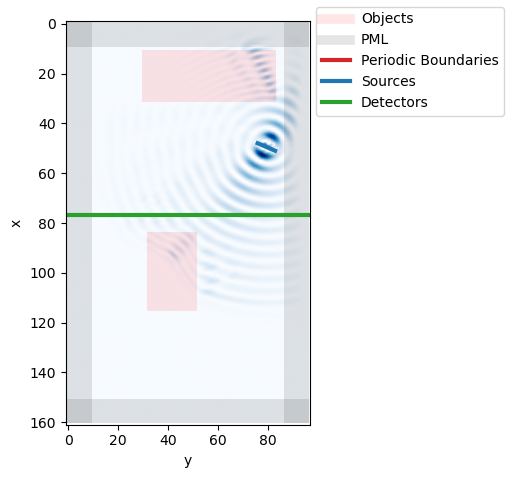

In [15]:
grid.visualize(z=0, show=False)
import matplotlib.pyplot as plt